# **Khởi tạo**

**Import thư viện**

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Flatten

**Đọc và xử lý dữ liệu**

In [16]:
def read_file(file_name):
    # Đọc dữ liệu từ file CSV
    data = pd.read_csv(file_name)

    # Chuyển cột 'Date' thành kiểu dữ liệu datetime và đặt làm index
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)

    # Chuyển đổi các cột khác sang dạng số nếu cần thiết
    data['Price'] = data['Price'].str.replace(',', '').astype(float)
    # Tiền xử lý các cột khác nếu cần thiết

    # Sắp xếp dữ liệu theo thời gian từ quá khứ đến hiện tại
    data.sort_index(inplace=True)

    return data

**Xây dựng mô hình**

In [37]:
# Hàm Create Dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [73]:
def CNN_LSTM_prediction(name, data, train_ratio=0.7):
    data = data.reset_index()['Price']

    # Chuẩn hóa dữ liệu
    scaler = MinMaxScaler(feature_range=(0,1))
    data = scaler.fit_transform(np.array(data).reshape(-1,1))

    # Chia train, test
    train_size = int(train_ratio * len(data))
    test_size = int((1-train_ratio) * len(data))
    train_data = data[:train_size]
    test_data = data[train_size:train_size+test_size]
    
    # Reshape into X=t,t+1,t+2..t+99 and Y=t+100
    time_step = 100
    X_train, y_train = create_dataset(train_data, time_step)
    X_test, y_test = create_dataset(test_data, time_step)
    
    # Reshape input to be [samples, time steps, features] which is required for LSTM
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
  
    # Xây dựng mô hình CNN-LSTM
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    # Fit mô hình với dữ liệu train
    model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

    # Dự báo dữ liệu test
    train_predict = model.predict(X_train)
    y_pred = model.predict(X_test)

    # Chuẩn hóa dữ liệu y_pred
    train_predict=scaler.inverse_transform(train_predict)
    y_pred=scaler.inverse_transform(y_pred)
    
    # Đánh giá độ chính xác thuật toán bằng RMSE
    train_rmse = np.sqrt(np.mean((train_predict - y_train)**2))
    test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
    print('Train RMSE:', train_rmse)
    print('Testing RMSE:', test_rmse)

    # Dự báo 30 ngày tiếp theo
    x_input = test_data[-time_step:].reshape(1, -1)
    temp_input = list(x_input[0])
    lst_output = []

    while len(lst_output) < 30:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[1:])
            x_input = x_input.reshape(1, -1)
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
        else:
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())

    # Vẽ hình
    plt.title('Linear Regression {} ({})'.format(train_ratio, name))
    plt.plot(scaler.inverse_transform(train_data))
    test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
    plt.plot(test_data_index,scaler.inverse_transform(test_data))
    test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
    plt.plot(test_data_index,(y_pred))
    prediect_data_index = pd.RangeIndex(start=len(data)-1, stop=len(data)+29, step=1)
    plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
    plt.legend(['Train','Test','Predict','Predict30days'])
    plt.show()

# **BIDV**

In [74]:
data = read_file("../Dataset/BID Historical Data.csv");
name = 'BIDV'

**BIDV 7:3**

Epoch 1/100


c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.1300
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0107
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0048
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0034
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0031
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0030
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0030
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0031
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0028
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0023
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0025
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0022
Epoch 13/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0022
Epoch 14/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0020
Epoch 15/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0020
E

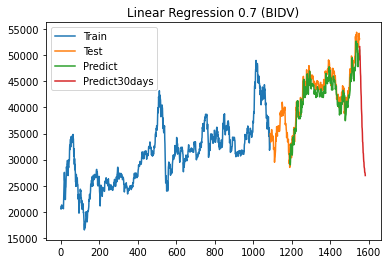

In [75]:
CNN_LSTM_prediction(name, data, 0.7)

**BIDV 8:2**

Epoch 1/100


c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.1925
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0338
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0061
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0050
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0044
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0040
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0040
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0034
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0032
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0033
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0029
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0025
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0024
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0022
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0024
E

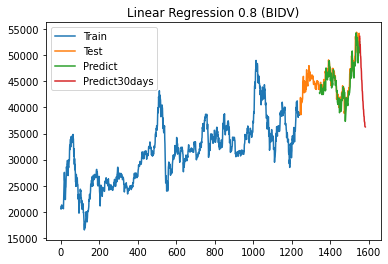

In [76]:
CNN_LSTM_prediction(name, data, 0.8)

**BIDV 9:1**

Epoch 1/100


c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.1605
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0092
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0035
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0029
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0030
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0029
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0024
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0024
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0024
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0023
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0020
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0019
Epoch 13/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0018
Epoch 14/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0018
Epoch 15/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0019
E

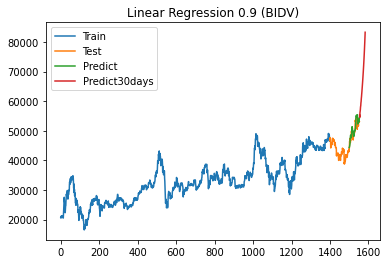

In [77]:
CNN_LSTM_prediction(name, data, 0.9)

# **VCB**

In [78]:
data = read_file("../Dataset/VCB Historical Data.csv");
name = 'VCB'

**VCB 7:3**

Epoch 1/100


c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.1158
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0089
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0029
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0022
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0016
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0017
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0017
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0015
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0015
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0016
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0014
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0014
Epoch 13/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0015
Epoch 14/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0013
Epoch 15/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0012
E

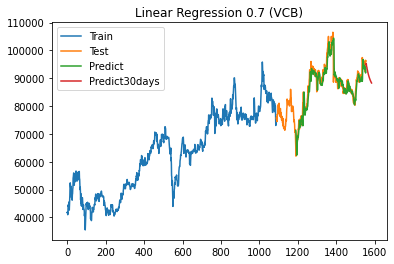

In [79]:
CNN_LSTM_prediction(name, data, 0.7)

**VCB 8:2**

Epoch 1/100


c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0973
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0046
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0025
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0021
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0021
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0018
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0016
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0016
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0019
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0019
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0014
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0014
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0013
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0014
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0013
E

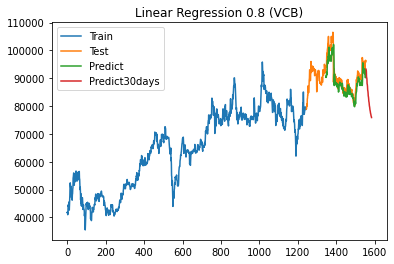

In [80]:
CNN_LSTM_prediction(name, data, 0.8)

**VCB 9:1**

Epoch 1/100


c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.1382
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0047
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0031
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0026
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0023
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0020
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0019
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0018
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0018
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0017
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0016
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0016
Epoch 13/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0016
Epoch 14/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0014
Epoch 15/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0015
E

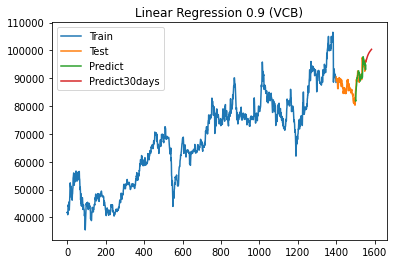

In [81]:
CNN_LSTM_prediction(name, data, 0.9)

# **MBB**

In [82]:
data = read_file("../Dataset/MBB Historical Data.csv");
name = 'MBB'

**MBB 7:3**

Epoch 1/100


c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.1423
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0138
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0052
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0029
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0021
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0019
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0019
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0017
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0016
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0016
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0015
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0013
Epoch 13/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0014
Epoch 14/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0013
Epoch 15/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0012
E

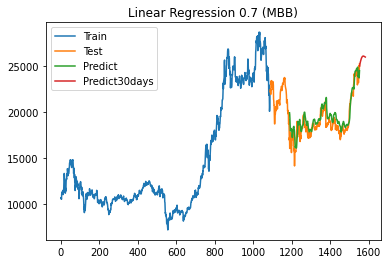

In [83]:
CNN_LSTM_prediction(name, data, 0.7)

**MBB 8:2**

Epoch 1/100


c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.1604
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0134
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0053
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0042
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0036
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0030
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0026
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0021
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0019
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0018
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0016
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0016
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0016
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0019
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0017
E

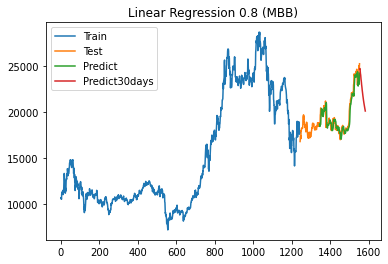

In [84]:
CNN_LSTM_prediction(name, data, 0.8)

**MBB 9:1**

Epoch 1/100


c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.1029
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0058
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0037
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0029
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0027
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0024
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0021
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0019
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0020
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0018
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0018
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0017
Epoch 13/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0016
Epoch 14/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0016
Epoch 15/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0014
E

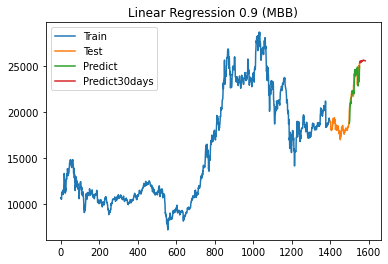

In [85]:
CNN_LSTM_prediction(name, data, 0.9)